In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

In [2]:
clear_session()

In [3]:
data = pd.read_csv('../data/data_banknote_authentication.txt', names=['variance', 'skew', 'curtosis', 'entropy', 'class'])
labels = data.pop('class')

data.head()


,variance,skew,curtosis,entropy
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


We are looking at bank note authentication data. 

In [4]:
X = np.array(data)
y = np.array(labels)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([762, 610], dtype=int64))

Our class balance is pretty good.

We build a densely-connected neural network with tensorflow.keras:

In [6]:
trainX, testX, trainY, testY = train_test_split(X, y)

In [7]:
model_sequential = tf.keras.Sequential()

In [8]:
model_sequential.add(tf.keras.layers.Input((4,)))
model_sequential.add(tf.keras.layers.Dense(10, activation='relu'))
model_sequential.add(tf.keras.layers.Dense(10, activation='relu'))
model_sequential.add(tf.keras.layers.Dropout(0.25))
model_sequential.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_sequential.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['acc'])

In [9]:
# Here we create a "callback" to observe validation performance.
# The network will stop fitting and keep the best model once the validation accuracy stops improving
es = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=200)]

In [10]:
history = model_sequential.fit(np.array(trainX), np.array(trainY), validation_split=0.2, callbacks=es, epochs=5000, verbose=0, batch_size=64)

Epoch 00946: early stopping


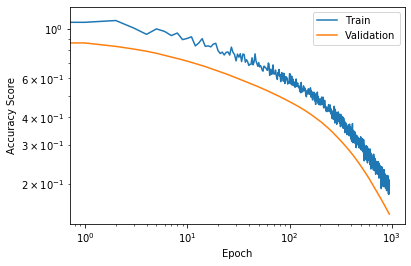

In [11]:
plt.loglog(history.history['loss'])
plt.loglog(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend(('Train', 'Validation'))
plt.show()

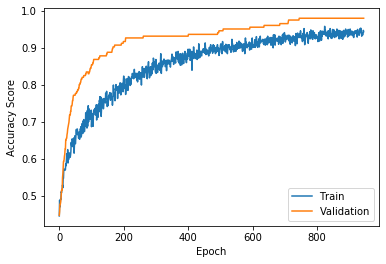

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend(('Train', 'Validation'))
plt.show()

In [13]:
train_predictions = np.round(model_sequential.predict(trainX))
test_predictions = np.round(model_sequential.predict(testX))

In [14]:
print('Train accuracy: {0:.3f}'.format(accuracy_score(trainY, train_predictions)))
print('Test accuracy: {0:.3f}'.format(accuracy_score(testY, test_predictions)))

print('Train F1 score: {0:.3f}'.format(f1_score(trainY, train_predictions)))
print('Test F1 score: {0:.3f}'.format(f1_score(testY, test_predictions)))

print('Train MCC: {0:.3f}'.format(matthews_corrcoef(trainY, train_predictions)))
print('Test MCC: {0:.3f}'.format(matthews_corrcoef(testY, test_predictions)))

Train accuracy: 0.988
Test accuracy: 0.983
Train F1 score: 0.987
Test F1 score: 0.980
Train MCC: 0.976
Test MCC: 0.965


Excellent performance! 

Next, we'll make a residual network using Keras' functional API, connecting the both the first and second layer to the output: 

In [15]:
inputs = tf.keras.layers.Input(shape=(4,))

output_1 = tf.keras.layers.Dense(10, activation='relu')(inputs)
output_2 = tf.keras.layers.Dense(10, activation='relu')(output_1)

# This layer simply merges the outputs of output_1 and output_2
output_3 = tf.keras.layers.concatenate([output_1, output_2])
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(output_3)

model_functional = tf.keras.Model(inputs=inputs, outputs=predictions)
model_functional.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['acc'])

model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           50          input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 10)           110         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20)           0           dense_3[0][0]                    
                                                                 dense_4[0][0]                

In [16]:
history = model_functional.fit(np.array(trainX), np.array(trainY), validation_split=0.2, callbacks=es, epochs=5000, verbose=0, batch_size=64)

Epoch 00666: early stopping


The model fit much more quickly.

In [17]:
train_predictions = np.round(model_sequential.predict(trainX))
test_predictions = np.round(model_sequential.predict(testX))

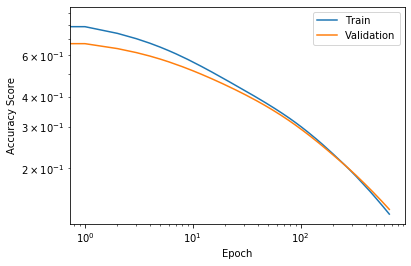

In [18]:
plt.loglog(history.history['loss'])
plt.loglog(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend(('Train', 'Validation'))
plt.show()

Much smoother convergence now

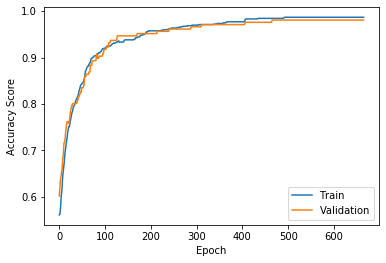

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend(('Train', 'Validation'))
plt.show()

In [20]:
print('Train accuracy: {0:.3f}'.format(accuracy_score(trainY, train_predictions)))
print('Test accuracy: {0:.3f}'.format(accuracy_score(testY, test_predictions)))

print('Train F1 score: {0:.3f}'.format(f1_score(trainY, train_predictions)))
print('Test F1 score: {0:.3f}'.format(f1_score(testY, test_predictions)))

print('Train MCC: {0:.3f}'.format(matthews_corrcoef(trainY, train_predictions)))
print('Test MCC: {0:.3f}'.format(matthews_corrcoef(testY, test_predictions)))

Train accuracy: 0.988
Test accuracy: 0.983
Train F1 score: 0.987
Test F1 score: 0.980
Train MCC: 0.976
Test MCC: 0.965


We still see excellent performance! 